# Predictive Maintenance for Manufacturing Equipment

*The dataset being analyzed contains sensor readings and operational parameters from an industrial machine, where the goal is to predict failure types. This classification task is crucial for preventive maintenance and ensuring smooth operation in industrial settings. Each row represents a snapshot of the machine's operational state at a given time, while each column contains a specific type of sensor reading or machine attribute.*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import os
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report,fbeta_score, make_scorer, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import display


In [3]:
client = MongoClient('mongodb://localhost:27017')
db = client['FinalProject']
collection = db['PredictiveMaintainence']
result = list(collection.find())
data = pd.DataFrame(result)
data.head()

,_id,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,66dfa610b36cab38adf5d0b9,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,66dfa610b36cab38adf5d0ba,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,66dfa610b36cab38adf5d0bb,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,66dfa610b36cab38adf5d0bc,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,66dfa610b36cab38adf5d0bd,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
data.shape

(10000, 11)

In [5]:
data.columns

Index(['_id', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      10000 non-null  object 
 1   UDI                      10000 non-null  int64  
 2   Product ID               10000 non-null  object 
 3   Type                     10000 non-null  object 
 4   Air temperature [K]      10000 non-null  float64
 5   Process temperature [K]  10000 non-null  float64
 6   Rotational speed [rpm]   10000 non-null  int64  
 7   Torque [Nm]              10000 non-null  float64
 8   Tool wear [min]          10000 non-null  int64  
 9   Target                   10000 non-null  int64  
 10  Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 859.5+ KB


In [7]:
data = data.drop('_id', axis=1)

In [8]:
#checking whether product ID is categorical feature or unique identifier
if(data['Product ID'].nunique() == data.shape[0]):
    print("No Duplicates in Product ID")

No Duplicates in Product ID


In [9]:
# No Duplicates in Product ID shows that it is unique identifier 
# but it also contains the type of the product
Product_ID_type = data['Product ID'].apply(lambda x: x[0])
Product_ID_type.value_counts()

Product ID
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [10]:
data['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [11]:
# The type in product ID is equivalent to Type feature so we can consider Product ID as unique values 
# removing unique values
data.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [12]:
data.head(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure


In [13]:
data.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [14]:
data = data.rename(columns = {'Air temperature [K]': 'Air temperature', 'Process temperature [K]': 'Process temperature',
       'Rotational speed [rpm]': 'Rotational speed', 'Torque [Nm]': 'Torque', 'Tool wear [min]': 'Tool wear'})

In [15]:
sensor_readings = ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']

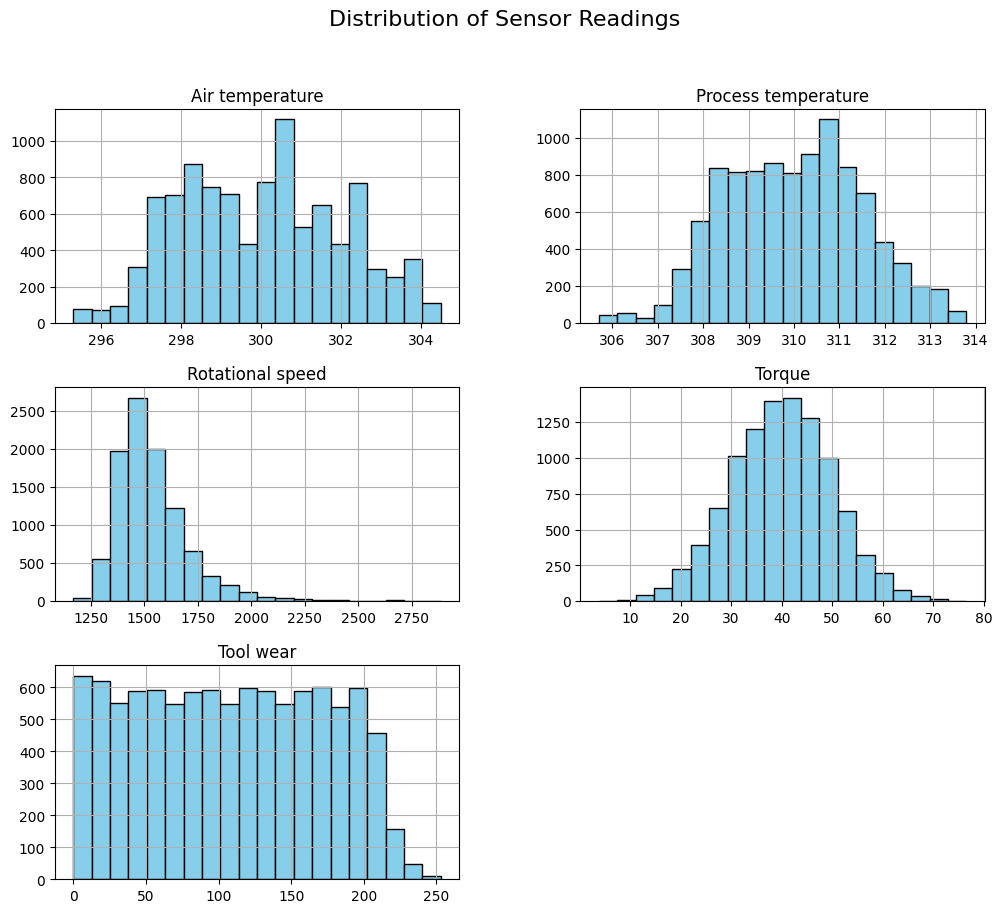

In [16]:
data[sensor_readings].hist(figsize=(12,10), bins=20, color='skyblue', edgecolor = 'black')
plt.suptitle('Distribution of Sensor Readings', fontsize=16)
plt.show()

In [17]:
df = data.copy()

In [18]:
print('skewness before log transformation: ', df['Rotational speed'].skew())
df['Rotational speed'] = np.log(df['Rotational speed'])
print('skewness after log transformation: ', df['Rotational speed'].skew())

skewness before log transformation:  1.9931710047137523
skewness after log transformation:  1.309369616254158


Outlier

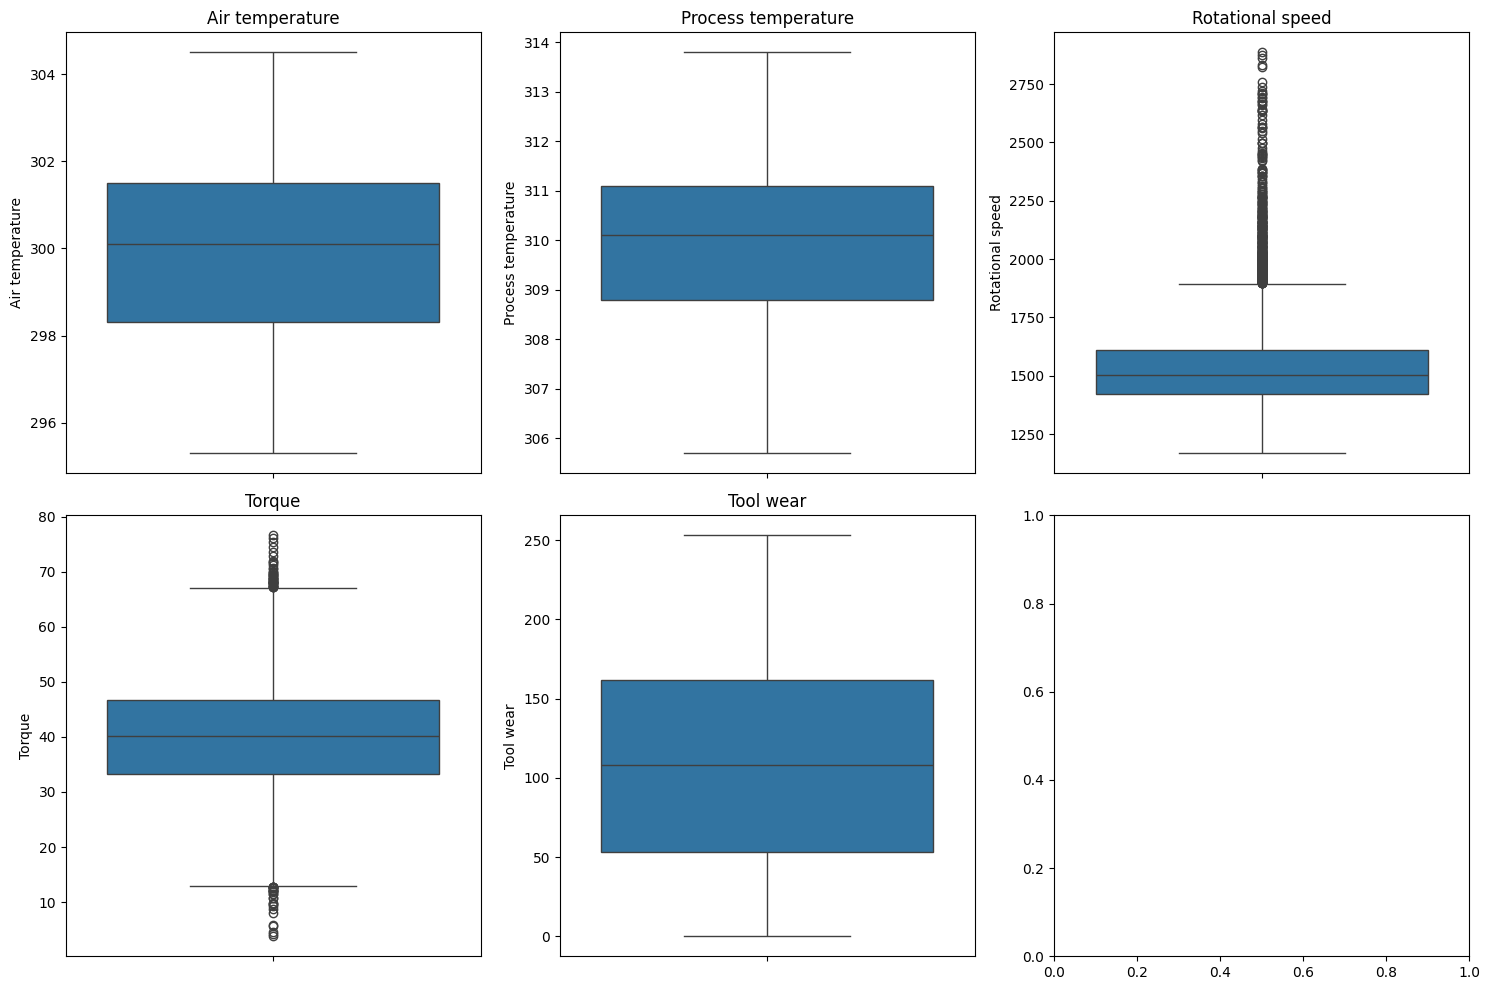

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for i, col in enumerate(data[sensor_readings]):
    row, column = i//3, i%3
    sns.boxplot(data = data[col], ax = axes[row,column])
    axes[row, column].set_title(col)

plt.tight_layout()
plt.show()

In [20]:
def count_outliers(df, col):
    z_scores = np.abs(zscore(df[col]))
    count = (z_scores > 3).sum()
    return count

In [21]:
for col in sensor_readings:
    outlier_count = count_outliers(df, col)
    print(f"{col}: {outlier_count}")

Air temperature: 0
Process temperature: 0
Rotational speed: 144
Torque: 25
Tool wear: 0


In [22]:
def remove_outliers(df, col):
    z_scores = df[col].apply(zscore)
    outliers = z_scores[(z_scores > 3) | (z_scores < -3)]
    df_cleaned = df[~outliers.any(axis=1)]
    return df_cleaned

In [23]:
cleaned_df = remove_outliers(df, sensor_readings)

In [24]:
cleaned_df.shape

(9842, 8)

Target and Failure Type Distribution

In [25]:
failure_percent = 100 * cleaned_df['Failure Type'].value_counts() / cleaned_df.shape[0]
failure_percent

Failure Type
No Failure                  96.921357
Heat Dissipation Failure     1.137980
Overstrain Failure           0.792522
Power Failure                0.518187
Tool Wear Failure            0.447064
Random Failures              0.182890
Name: count, dtype: float64

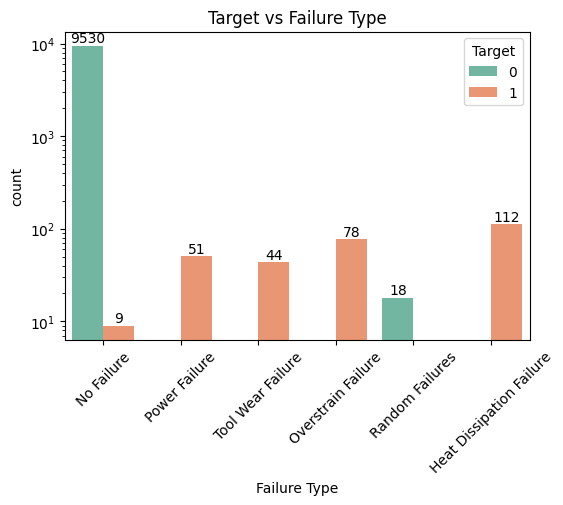

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x='Failure Type', data = cleaned_df, hue = 'Target', width=0.8, palette = 'Set2', legend = True)
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'bottom')
plt.yscale('log')
plt.title('Target vs Failure Type')
plt.xticks(rotation=45)
plt.show()

The above plot shows **9 No Failure type** having Target as 1 and **Random Failures Type** having all Target values as 0

In [27]:
outlier_removed_df = cleaned_df[~((cleaned_df['Failure Type']=='No Failure') & (cleaned_df['Target']==1))]
outlier_removed_df = outlier_removed_df[~(((outlier_removed_df['Failure Type']=='Random Failures') & (outlier_removed_df['Target']==0)))]
outlier_removed_df.shape, cleaned_df.shape
print('Total data points removed: ', data.shape[0] -outlier_removed_df.shape[0])

Total data points removed:  185


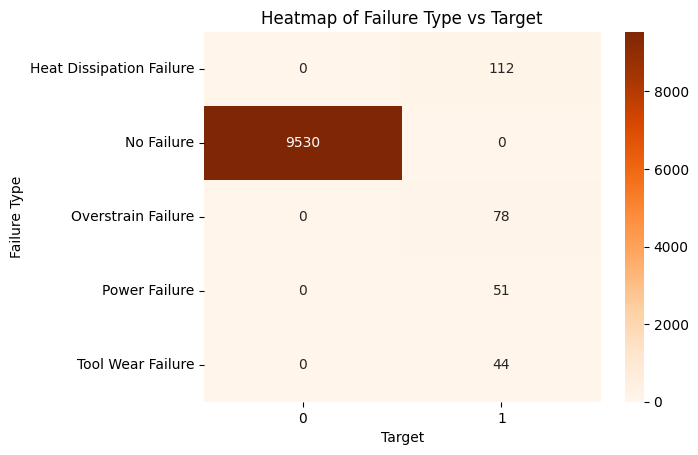

In [28]:
crosstab = pd.crosstab(outlier_removed_df['Failure Type'], outlier_removed_df['Target'])
sns.heatmap(crosstab, annot=True, fmt = ".0f", cmap='Oranges')
plt.title('Heatmap of Failure Type vs Target')
plt.show()

Encoding

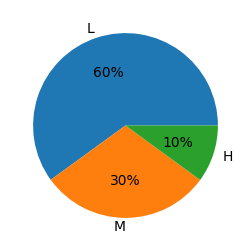

In [29]:
plt.figure(figsize=(3,3))
type_percent = 100 * data['Type'].value_counts() / data.shape[0]
plt.pie(x=type_percent.array, labels=type_percent.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

In [30]:
encoded_df = outlier_removed_df.copy()
encoded_df['Type'] = encoded_df['Type'].map({'L': 0, 'M': 1, 'H': 2})
encoded_df['Failure Type'] = encoded_df['Failure Type'].map({'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2,
                                                 'Overstrain Failure': 3, 'Heat Dissipation Failure': 4})
encoded_df.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
0,1,298.1,308.6,7.346655,42.8,0,0,0
1,0,298.2,308.7,7.249926,46.3,3,0,0
2,0,298.1,308.5,7.311886,49.4,5,0,0
3,0,298.2,308.6,7.267525,39.5,7,0,0
4,0,298.2,308.7,7.249926,40.0,9,0,0


Feature Engineering

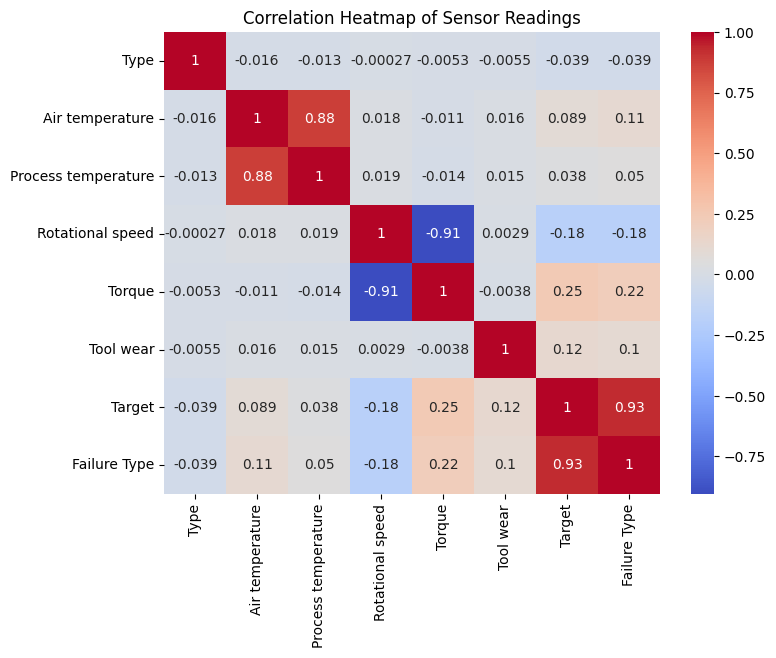

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(encoded_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Sensor Readings")
plt.show()

Scaling

In [32]:
sc = StandardScaler()
scaled_df = encoded_df.copy()
scaled_df[sensor_readings] = sc.fit_transform(scaled_df[sensor_readings])
scaled_df.head(2)

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
0,1,-0.950501,-0.945900,0.209995,0.263608,-1.69632,0,0
1,0,-0.900452,-0.878403,-0.812796,0.632583,-1.64916,0,0


In [33]:
with open(os.path.join('pickle','scaler.pkl'), 'wb') as f:
    pickle.dump(sc, f)

Insert cleaned data to DB

In [34]:
cleaned_data_collection = db['CleanedData']
data_to_be_inserted = scaled_df.to_dict('records')
res = cleaned_data_collection.insert_many(data_to_be_inserted)

In [35]:
result_data = list(cleaned_data_collection.find())
final_df = pd.DataFrame(result_data)
final_df = final_df.drop('_id', axis=1)

Handling imbalanced data

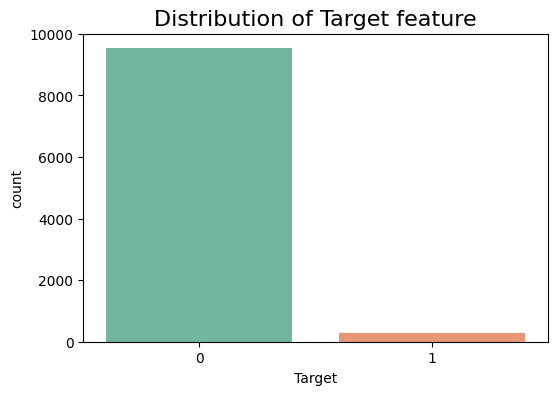

In [36]:
plt.figure(figsize=(6,4))
sns.countplot(x='Target', data=final_df, hue='Target', palette='Set2', legend=False)
plt.title('Distribution of Target feature', fontsize=16)
plt.show()

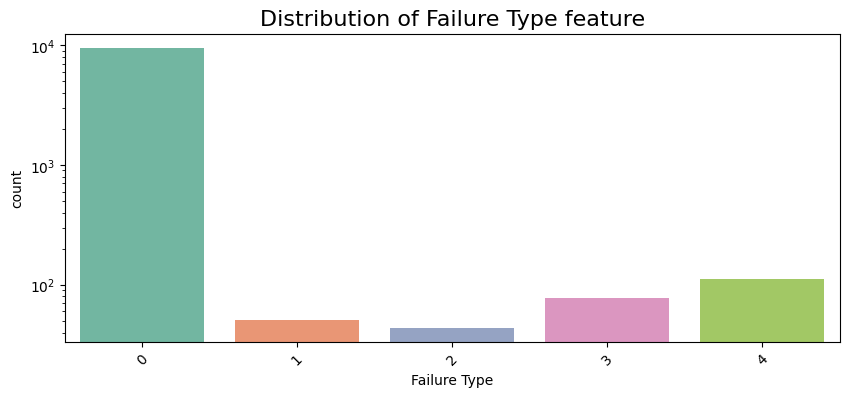

In [37]:
plt.figure(figsize=(10,4))
sns.countplot(x='Failure Type', data=final_df, hue='Failure Type', palette='Set2', legend=False)
plt.yscale('log')
plt.title('Distribution of Failure Type feature', fontsize=16)
plt.xticks(rotation=45)
plt.show()

Oversampling

In [38]:
no_failure = int((final_df['Failure Type'] == 0).sum())
minority_class = final_df['Failure Type'].nunique() - 1
minority_percent = 0.20
final_count = no_failure / (1 - minority_percent)
sample_per_class = round((final_count - no_failure) / minority_class)
sample_strategy = {0 : no_failure}
for i in range(1, minority_class+1):
    sample_strategy[i] = sample_per_class
print(sample_strategy)

{0: 9530, 1: 596, 2: 596, 3: 596, 4: 596}


In [39]:
smote = SMOTENC(categorical_features=[0,6], sampling_strategy=sample_strategy, random_state=42)
X_res, y_res = smote.fit_resample(final_df, final_df['Failure Type'])

In [71]:
with open(os.path.join('pickle', 'resample.pkl'), 'wb') as f:
    pickle.dump(smote, f)

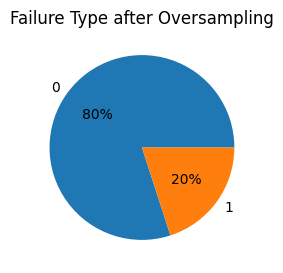

In [40]:
plt.figure(figsize=(4,3))
X_res_percent = 100 * X_res['Target'].value_counts() / X_res['Target'].shape[0]
plt.pie(x=X_res_percent.array, labels=X_res_percent.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.title('Failure Type after Oversampling')
plt.show()

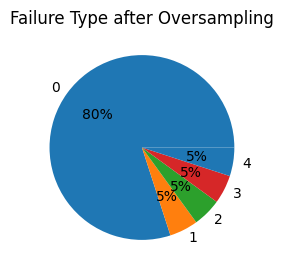

In [41]:
plt.figure(figsize=(4,3))
y_res_percent = 100 * y_res.value_counts() / y_res.shape[0]
plt.pie(x=y_res_percent.array, labels=y_res_percent.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.title('Failure Type after Oversampling')
plt.show()

Train - Validation - Test set Split

In [42]:
X = X_res.drop(['Target', 'Failure Type'], axis=1)
y = X_res[['Target', 'Failure Type']]

In [43]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.20, stratify=y['Failure Type'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem['Failure Type'], random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape)

(9531, 6) (1191, 6) (9531, 2) (1191, 2) (1192, 6) (1192, 2)


In [44]:
print(f'Train set percentage: {X_train.shape[0] * 100 /X_res.shape[0] : .2f}%')
print(f'Validation set percentage: {X_val.shape[0] * 100 /X_res.shape[0] : .2f}%')
print(f'Test set percentage: {X_test.shape[0] * 100 /X_res.shape[0] : .2f}%')

Train set percentage:  80.00%
Validation set percentage:  10.00%
Test set percentage:  10.01%


### Supervised Learning - Binary Classification

In [45]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators':[100,300,500,700],
            'max_depth':[5,7,10],
            'random_state':[0]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'param_grid': {
            'n_estimators':[300,500,700],
            'max_depth':[5,7],
            'learning_rate':[0.01,0.1],
            'objective':['binary:logistic']
        }
    },
    'Neural Network': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'param_grid': {
            'hidden_layer_sizes': [(10,), (20,)],
            'activation': ['relu'], 
            'solver': ['adam'],      
            'alpha': [0.0001],   
            'learning_rate': ['constant'] 
        }
    }
}

In [46]:
def evaluate_binary_models(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test['Target'], y_pred)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    acc = round(accuracy_score(y_test['Target'], y_pred), 3)
    auc = round(roc_auc_score(y_test['Target'], y_pred_prob), 3)
    f1 = round(f1_score(y_test['Target'], y_pred, pos_label=1), 3)
    
    metrics = {
        'model': model.__class__.__name__,
        'accuracy': acc,
        'roc score': auc,
        'f1 score': f1,
    }
    return metrics, cm

In [47]:
def conf_matrix(cm_list, title, class_labels):
    fig, axes = plt.subplots(nrows=1, ncols=len(cm_list), figsize=(18, 5))

    fig.suptitle(f'Confusion Matrices for {title}', fontsize=16)

    for i, (name, cm) in enumerate(cm_list.items()):
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                    xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(name)
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [48]:
fitted_models = {}
for name, details in models.items():
    model = details['model']
    params = details['param_grid']

    print(f'Fitting and Tuning {name}...')

    f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring=f2_scorer)
    grid_search.fit(X_train, y_train['Target'])
    best_params = grid_search.best_params_

    fitted_models[name] = {
        'model': grid_search.best_estimator_,
        'best_params': best_params
    }
    print(best_params)

Fitting and Tuning Random Forest...
{'max_depth': 10, 'n_estimators': 700, 'random_state': 0}
Fitting and Tuning XGBoost...
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'objective': 'binary:logistic'}
Fitting and Tuning Neural Network...
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [49]:
val_metrics_list = []
val_cm_list = {}
test_metrics_list = []
test_cm_list = {}

for name, details in fitted_models.items():
    val_metrics, val_cm = evaluate_binary_models(details['model'], X_val, y_val)
    
    val_cm_list[name] = val_cm
    
    val_metrics_list.append({
        'Model' : name,
        'Accuracy' : val_metrics['accuracy'],
        'ROC Score' : val_metrics['roc score'],
        'F1 score': val_metrics['f1 score']
       })
    
    val_metrics_df = pd.DataFrame(val_metrics_list)

    test_metrics, test_cm = evaluate_binary_models(details['model'], X_test, y_test)
    
    test_cm_list[name] = test_cm
    
    test_metrics_list.append({
        'Model' : name,
        'Accuracy' : test_metrics['accuracy'],
        'ROC Score' : test_metrics['roc score'],
        'F1 score': test_metrics['f1 score']
       })
    test_metrics_df = pd.DataFrame(test_metrics_list)

In [50]:
print('Evaluation Metrics of Validation Dataset')
display(val_metrics_df)
print('Evaluation Metrics of Test Dataset')
display(test_metrics_df)

Evaluation Metrics of Validation Dataset


,Model,Accuracy,ROC Score,F1 score
0,Random Forest,0.981,0.998,0.953
1,XGBoost,0.986,0.999,0.965
2,Neural Network,0.966,0.991,0.915


Evaluation Metrics of Test Dataset


,Model,Accuracy,ROC Score,F1 score
0,Random Forest,0.975,0.998,0.940
1,XGBoost,0.987,0.999,0.969
2,Neural Network,0.956,0.992,0.893


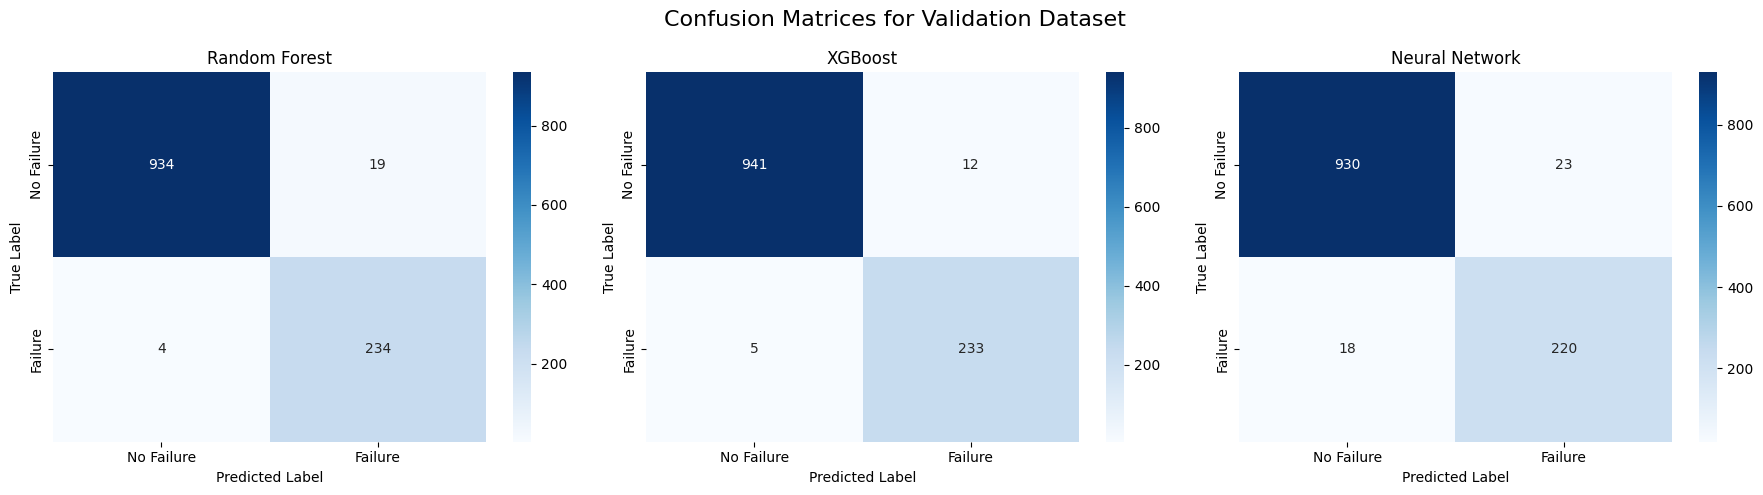

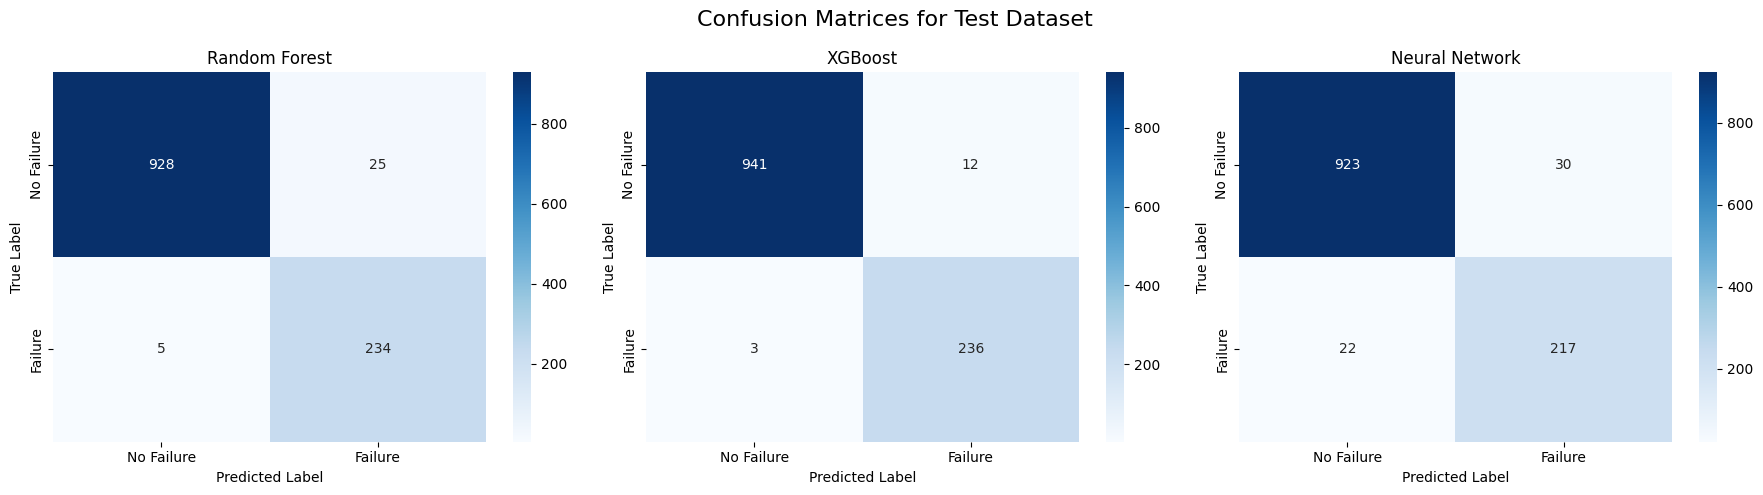

In [51]:
class_labels = ['No Failure', 'Failure']
conf_matrix(val_cm_list, 'Validation Dataset', class_labels)
conf_matrix(test_cm_list, 'Test Dataset', class_labels)

### Supervised Learning - Multi Class Classification

In [52]:
fitted_models_multi = {}
for name, details in models.items():
    model = details['model']
    params = details['param_grid']

    print(f'Fitting and Tuning {name}...')

    f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring=f2_scorer)
    grid_search.fit(X_train, y_train['Failure Type'])
    best_params = grid_search.best_params_

    fitted_models_multi[name] = {
        'model': grid_search.best_estimator_,
        'best_params': best_params
    }
    print(best_params)

Fitting and Tuning Random Forest...
{'max_depth': 10, 'n_estimators': 100, 'random_state': 0}
Fitting and Tuning XGBoost...
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700, 'objective': 'binary:logistic'}
Fitting and Tuning Neural Network...
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [53]:
def evaluate_multiclass_models(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test['Failure Type'], y_pred)
    y_pred_prob = model.predict_proba(X_test)
    acc = round(accuracy_score(y_test['Failure Type'], y_pred), 3)
    auc = round(roc_auc_score(y_test['Failure Type'], y_pred_prob,multi_class='ovr', average='weighted'), 3)
    f1 = round(f1_score(y_test['Failure Type'], y_pred, average='weighted'), 3)
    
    metrics = {
        'model': model.__class__.__name__,
        'accuracy': acc,
        'roc score': auc,
        'f1 score': f1,
    }
    return metrics, cm

In [54]:
val_metrics_list_multi = []
val_cm_list_multi = {}
test_metrics_list_multi = []
test_cm_list_multi = {}

for name, details in fitted_models_multi.items():
    val_metrics_multi, val_cm_multi = evaluate_multiclass_models(details['model'], X_val, y_val)
    
    val_cm_list_multi[name] = val_cm_multi
    
    val_metrics_list_multi.append({
        'Model' : name,
        'Accuracy' : val_metrics_multi['accuracy'],
        'ROC Score' : val_metrics_multi['roc score'],
        'F1 score': val_metrics_multi['f1 score']
       })
    
    val_metrics_df_multi = pd.DataFrame(val_metrics_list_multi)

    test_metrics_multi, test_cm_multi = evaluate_multiclass_models(details['model'], X_test, y_test)
    
    test_cm_list_multi[name] = test_cm_multi
    
    test_metrics_list_multi.append({
        'Model' : name,
        'Accuracy' : test_metrics_multi['accuracy'],
        'ROC Score' : test_metrics_multi['roc score'],
        'F1 score': test_metrics_multi['f1 score']
       })
    test_metrics_df_multi = pd.DataFrame(test_metrics_list_multi)

In [55]:
print('Evaluation Metrics of Validation Dataset')
display(val_metrics_df_multi)
print('Evaluation Metrics of Test Dataset')
display(test_metrics_df_multi)

Evaluation Metrics of Validation Dataset


,Model,Accuracy,ROC Score,F1 score
0,Random Forest,0.978,0.998,0.979
1,XGBoost,0.987,0.999,0.987
2,Neural Network,0.965,0.995,0.965


Evaluation Metrics of Test Dataset


,Model,Accuracy,ROC Score,F1 score
0,Random Forest,0.977,0.998,0.977
1,XGBoost,0.991,0.999,0.991
2,Neural Network,0.972,0.996,0.973


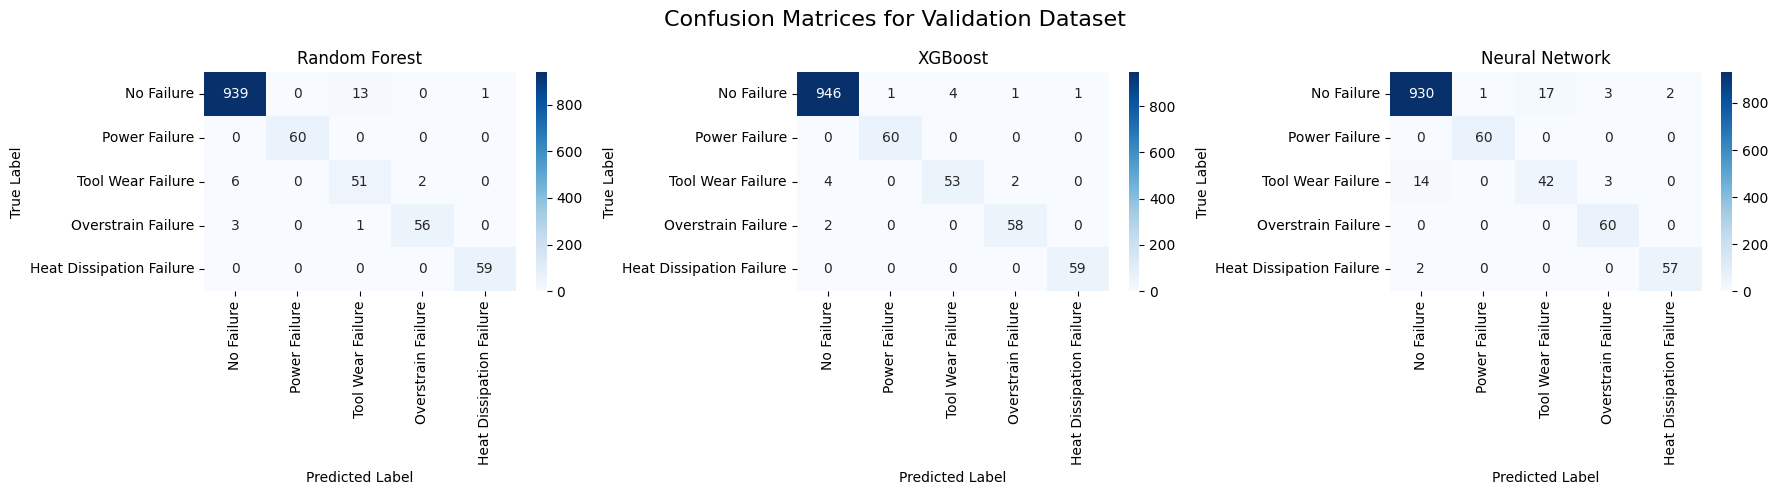

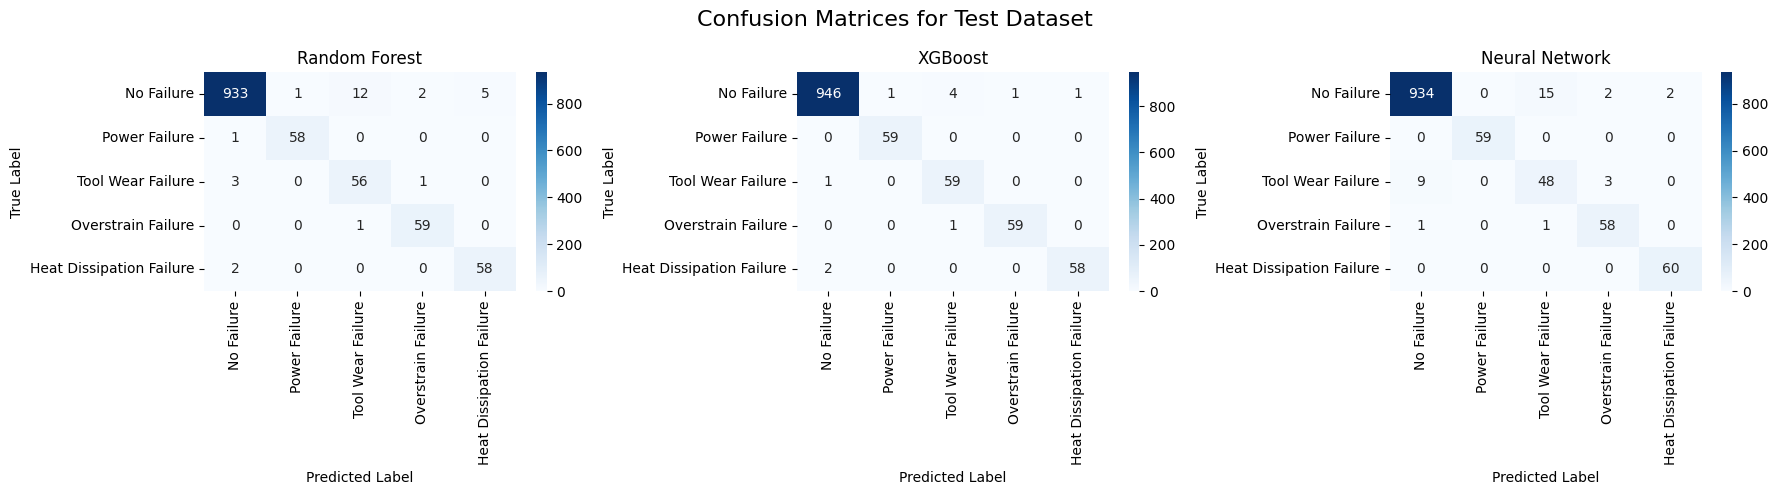

In [56]:
class_labels = ['No Failure', 'Power Failure', 'Tool Wear Failure', 'Overstrain Failure', 'Heat Dissipation Failure']
conf_matrix(val_cm_list_multi, 'Validation Dataset', class_labels)
conf_matrix(test_cm_list_multi, 'Test Dataset', class_labels)

Unsupervised Learning - Binary Classification

In [57]:
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [58]:
kmeans_param = {
    'n_clusters': [2, 3, 4, 5, 6],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30]
}
kmeans = KMeans(random_state=42)
kmeans_grid = GridSearchCV(kmeans, kmeans_param, cv=5, n_jobs=-1)
kmeans_grid.fit(X_pca)
labels_pca = kmeans_grid.best_estimator_.predict(X_test_pca)
silhouette_avg_pca = silhouette_score(X_test_pca, labels_pca)
print(f"Silhouette Score: {silhouette_avg_pca}")

Silhouette Score: 0.3260494629970224


In [60]:
isof = IsolationForest(random_state = 42)
iso_param = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.6, 0.8],
    'contamination': [0.01, 0.02, 0.05], 
    'max_features': [1.0, 0.8, 0.6]
}
iso_grid = GridSearchCV(isof, iso_param, cv=5, n_jobs=-1, scoring = 'accuracy')
iso_grid.fit(X_train, y_train['Target'])
y_pred_anomalies = iso_grid.best_estimator_.predict(X_test)
y_pred_anomalies = np.where(y_pred_anomalies == -1, 1, 0)
roc_auc = roc_auc_score(y_test['Target'], y_pred_anomalies)
roc_auc

np.float64(0.49580272822665267)

In [ ]:
isof = IsolationForest(random_state = 42)
iso_param = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.6, 0.8],
    'contamination': [0.01, 0.02, 0.05], 
    'max_features': [1.0, 0.8, 0.6]
}
iso_grid = GridSearchCV(isof, iso_param, cv=5, n_jobs=-1, scoring = 'accuracy')
iso_grid.fit(X_train, y_train['Failure Type'])
y_pred_anomalies = iso_grid.best_estimator_.predict(X_test_pca)
y_pred_anomalies = np.where(y_pred_anomalies == -1, 1, 0)
roc_auc = roc_auc_score(y_test['Failure Type'], y_pred_anomalies)
roc_auc

In [66]:
binary_model = fitted_models['XGBoost']['model']
binary_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [68]:
with open(os.path.join('pickle', 'binary_xbg.pkl'),'wb') as f:
    pickle.dump(binary_model, f)

In [69]:
multi_model = fitted_models_multi['XGBoost']['model']
multi_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [70]:
with open(os.path.join('pickle', 'multi_xbg.pkl'),'wb') as f:
    pickle.dump(multi_model, f)